# Lidar processing in R 

We start by importing the `lidR` package for LiDAR processing.

In [39]:
# The latest released version from CRAN with
library("lidR")

__Functions I want to use__:
- __decimate_points__: allows me to simulate lower point densities (use with `homogenize` algorithm) 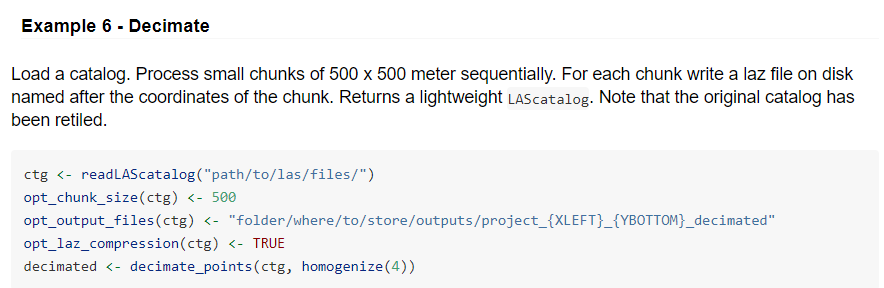
- __grid_terrain__: With `tin` algorithm 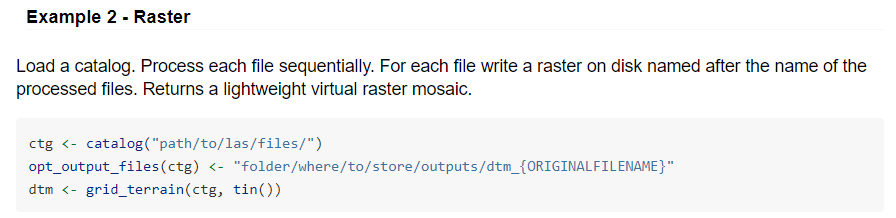
- __classify_ground__:
- __normalise_height__:
- __grid_metrics__:
- (__grid_canopy__)

## 1. Set paths

Next, we set the paths of the files that we want to explore.

In [3]:
# Paisagenslidar data
# Note: this comes in a folder of smaller files (blue)
san_paisagens_folder <- "/gws/nopw/j04/forecol/data/Paisagenslidar/Mission_2014/SAN_A02_2014_LiDAR/SAN_A02_2014_laz"

# EBA data:
# Note: this comes in a single file
san_eba_file <- "/gws/nopw/j04/forecol/data/EBA_lidar/clouds7/NP_T-0859.laz"

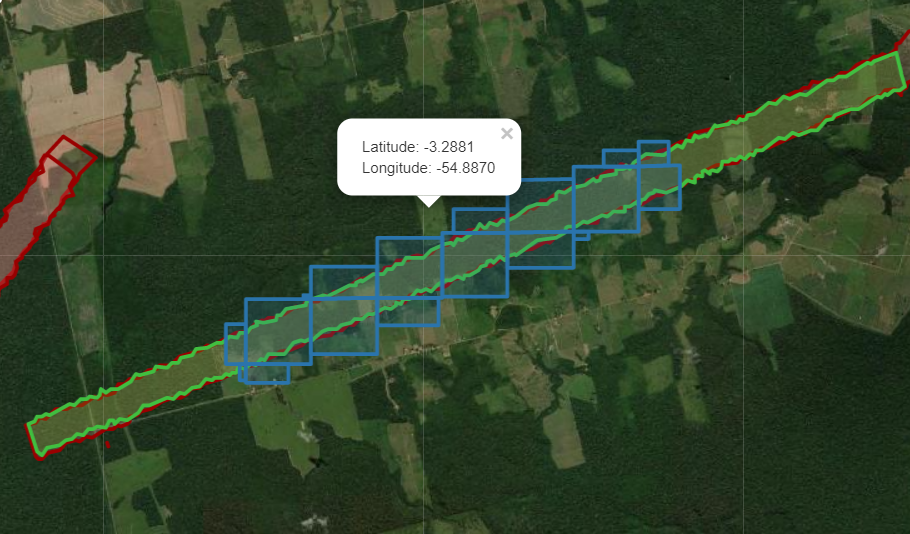

## 2. Load data

### 2.1 Read Paisagenslidar data

Note: We read it as a [lidar catalog](https://jean-romain.github.io/lidRbook/engine.html)

Backgroud on [LASCatalog](https://cran.r-project.org/web/packages/lidR/vignettes/lidR-LAScatalog-class.html)  
Background on [LASCatalog Processing Engine](https://cran.r-project.org/web/packages/lidR/vignettes/lidR-LAScatalog-engine.html)
More info on processing [lidar catalogs](https://github.com/Jean-Romain/lidR/wiki/Make-cheap-High-Performance-Computing-to-process-large-datasets)

In [4]:
san_paisagens <- readLAScatalog(san_paisagens_folder)

Warning message in data.table::rbindlist(headers):
“Column 28 ['Extended.Variable.Length.Records'] of item 1 is length 0. This (and 17 others like it) has been filled with NA (NULL for list columns) to make each item uniform.”Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.9.1-CAPI-1.14.2
and GEOS at installation 3.9.1dev-CAPI-1.14.1differ”

Let's do a quick check of the data

In [5]:
san_paisagens

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson
Warning message in clean_columns(as.data.frame(obj), factorsAsCharacter):
“Dropping column(s) Extended.Variable.Length.Records of class(es) list”

class       : LAScatalog (v1.0 format 1)
extent      : 731691.8, 738622.2, 9633725, 9637361 (xmin, xmax, ymin, ymax)
coord. ref. : NA 
area        : 8.35 kunits²
points      : 408.94 million points
density     : 49 points/units²
num. files  : 18 

In [34]:
summary(san_paisagens)

class       : LAScatalog (v1.0 format 1)
extent      : 731691.8, 738622.2, 9633725, 9637361 (xmin, xmax, ymin, ymax)
coord. ref. : NA 
area        : 8.35 kunits²
points      : 408.94 million points
density     : 49 points/units²
num. files  : 18 
proc. opt.  : buffer: 30 | chunk: 0
input opt.  : select: * | filter: 
output opt. : in memory | w2w guaranteed | merging enabled
drivers     :
 - Raster : format = GTiff  NAflag = -999999  
 - LAS : no parameter
 - Spatial : overwrite = FALSE  
 - SimpleFeature : quiet = TRUE  
 - DataFrame : no parameter


In [6]:
las_check(san_paisagens)


 Checking headers consistency
  - Checking file version consistency... ✓
  - Checking scale consistency... ✓
  - Checking offset consistency... ✓
  - Checking point type consistency... ✓
  - Checking VLR consistency... ✓
  - Checking CRS consistency... ✓
 Checking the headers
  - Checking scale factor validity... ✓
  - Checking Point Data Format ID validity... ✓
 Checking preprocessing already done 
  - Checking negative outliers... ✓
  - Checking normalization... no
 Checking the geometry
  - Checking overlapping tiles... ✓
  - Checking point indexation... no

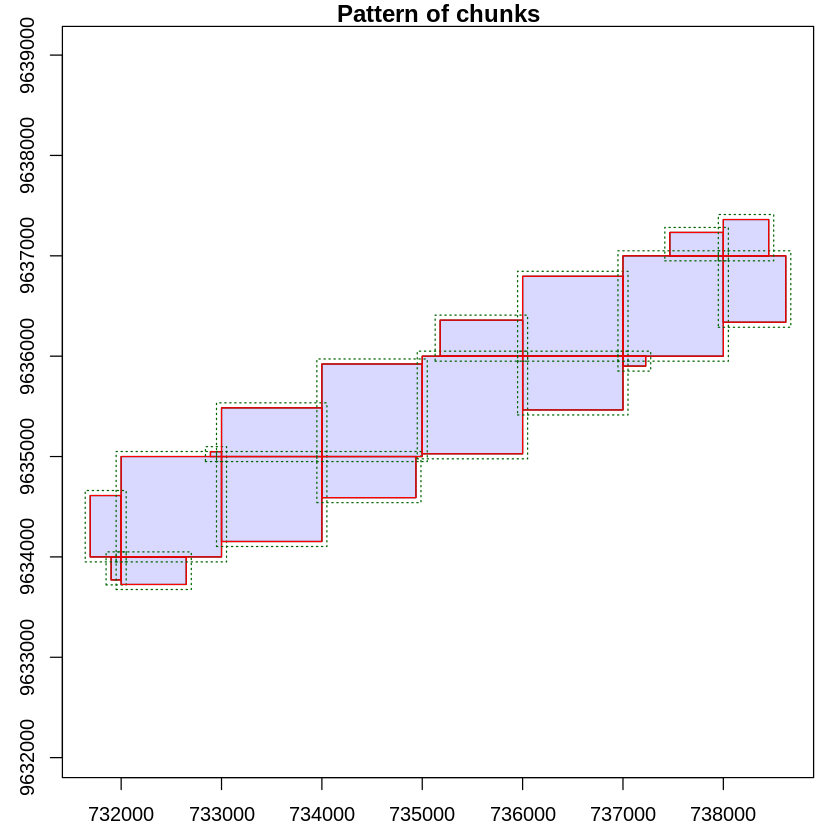

In [38]:
# Show chunks around the files in the catalog

# Note: to optinally set specifics chunks, use this:
# opt_chunk_size(san_paisagens) <- 1000

opt_chunk_buffer(san_paisagens) <- 50 # 200 m buffer
plot(san_paisagens, chunk=TRUE)

To get detailed analysis, use:

In [8]:
#las_check(san_paisagens, deep=TRUE)

### 2.2 Read EBA data

Background on [LAS files](https://cran.r-project.org/web/packages/lidR/vignettes/lidR-LAS-class.html)

A LAS object is composed of four slots: @data, @header, @proj4string and @bbox, and inherits Spatial from package sp.

In [9]:
san_eba <- readLAS(san_eba_file)

Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
“Discarded datum Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000 in CRS definition”

Get an overview of the data

In [10]:
san_eba

class        : LAS (v1.3 format 1)
memory       : 4.1 Gb 
extent       : 728683.1, 742070.4, 9632634, 9638704 (xmin, xmax, ymin, ymax)
coord. ref.  : SIRGAS 2000 / UTM zone 21S 
area         : 9.29 km²
points       : 55.05 million points
density      : 5.93 points/m²

To get a detailed check, run

In [44]:
# Note: $ is selector for named columns/elements (like dict)
#     [[]] is selector for elements of a list/vector by index
san_eba$Classification[[1]]

[1] 2

In [60]:
is.null(san_paisagens$Classification[[1]])

[1] TRUE

In [50]:
attributes(san_paisagens)

In [58]:
is.null(readLAS(san_paisagens$filename[[1]])$Classification[[1]])

[1] FALSE

### Capturing output from las_check

In [62]:
check <- capture.output(las_check(readLAS(san_paisagens$filename[[1]])))

In [72]:
capture.output(las_check(readLAS(san_paisagens$filename[[1]])), file="./test_check")

In [107]:
#library("stringr")

In [123]:
str_replace_all(
    paste(check, 
          collapse=" \n "), 
    regex("\\033\\[32m|\\033\\[39m|\\033\\[33m|\\033\\[31m"), 
    ""
)

[1] " \n  Checking the data \n   - Checking coordinates... ✓ \n   - Checking coordinates type... ✓ \n   - Checking coordinates quantization... ✓ \n   - Checking attributes type... ✓ \n   - Checking ReturnNumber validity... ✓ \n   - Checking NumberOfReturns validity... ✓ \n   - Checking ReturnNumber vs. NumberOfReturns... ✓ \n   - Checking RGB validity... ✓ \n   - Checking absence of NAs... ✓ \n   - Checking duplicated points... \n    ⚠ 1016 points are duplicated and share XYZ coordinates with other points \n   - Checking degenerated ground points... \n    ⚠ There were 25 degenerated ground points. Some X Y Z coordinates were repeated. \n   - Checking attribute population... \n    ⚠ 'ScanDirectionFlag' attribute is not populated. \n    ⚠ 'EdgeOfFlightline' attribute is not populated. \n   - Checking gpstime incoherances \n     ✗ 14866 pulses (points with the same gpstime) have points with identical ReturnNumber \n   - Checking flag attributes... ✓ \n   - Checking user data attribute... \n    ⚠ 415987 points have a non 0 UserData attribute. This probably has a meaning. \n  Checking the header \n   - Checking header completeness... ✓ \n   - Checking scale factor validity... ✓ \n   - Checking point data format ID validity... ✓ \n   - Checking extra bytes attributes validity... ✓ \n   - Checking the bounding box validity... ✓ \n   - Checking coordinate reference sytem... ✓ \n  Checking header vs data adequacy \n   - Checking attributes vs. point format... ✓ \n   - Checking header bbox vs. actual content... ✓ \n   - Checking header number of points vs. actual content... ✓ \n   - Checking header return number vs. actual content... ✓ \n  Checking preprocessing already done  \n   - Checking ground classification... yes \n   - Checking normalization... no \n   - Checking negative outliers... ✓ \n   - Checking flightline classification... yes"

In [ ]:
#las_check(san_eba)

## 3. Ground classification

In [69]:
san_eba

class        : LAS (v1.3 format 1)
memory       : 4.1 Gb 
extent       : 728683.1, 742070.4, 9632634, 9638704 (xmin, xmax, ymin, ymax)
coord. ref.  : SIRGAS 2000 / UTM zone 21S 
area         : 9.29 km²
points       : 55.05 million points
density      : 5.93 points/m²

In [64]:
help(classify_ground)

classify_ground {lidR},R Documentation
las,An object of class LAS or LAScatalog.
algorithm,a ground-segmentation function. lidR has: pmf and csf.
last_returns,"logical. The algorithm will use only the last returns (including the first returns in cases of a single return) to run the algorithm. If FALSE all the returns are used. If the attribute 'ReturnNumber' or 'NumberOfReturns' are absent, 'last_returns' is turned to FALSE automatically."


## 4. Digital terrain model creation

Ideally, for best results we do this in memory

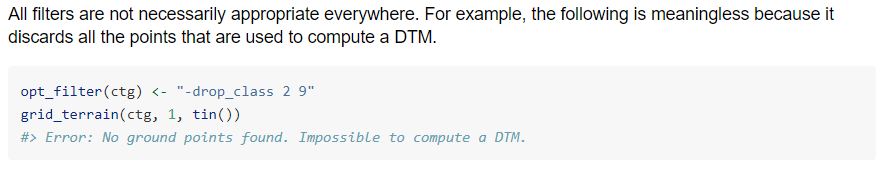

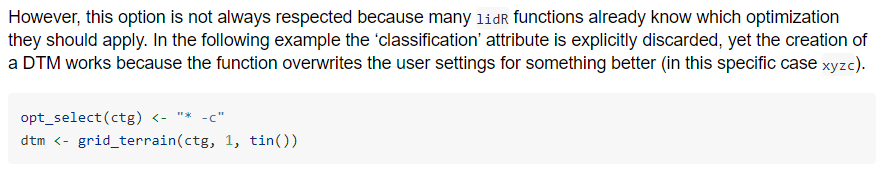

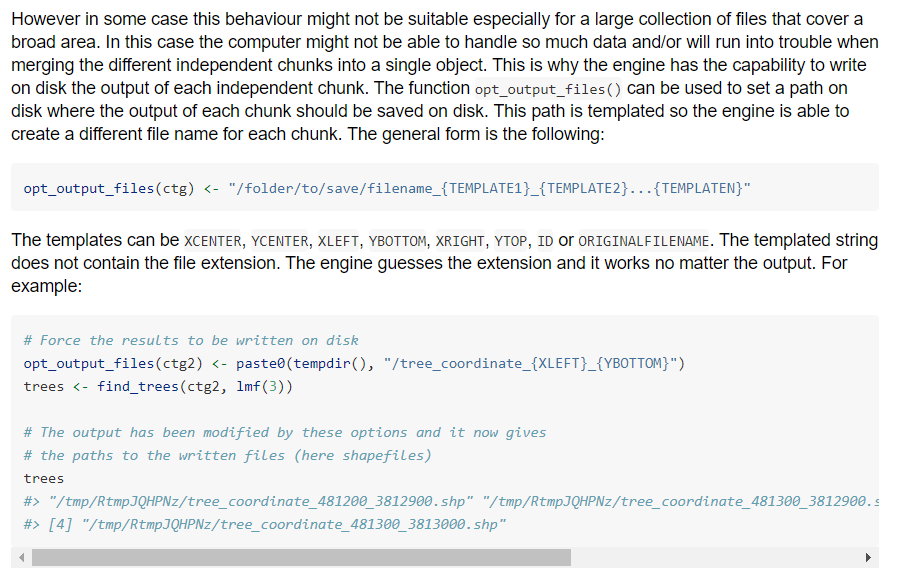

In [ ]:
# To set where to save the DTM
# opt_output_files(san_paisagens) <- "folder/where/to/store/outputs/dtm_{ORIGINALFILENAME}"

In [70]:
help(grid_terrain)

grid_terrain {lidR},R Documentation
las,An object of class LAS or LAScatalog.
res,numeric. The resolution of the output Raster. Can optionally be a RasterLayer. In that case the RasterLayer is used as the layout.
algorithm,"function. A function that implements an algorithm to compute spatial interpolation. lidR implements knnidw, tin, and kriging (see respective documentation and examples)."
keep_lowest,logical. This option forces the original lowest ground point of each cell (if it exists) to be chosen instead of the interpolated values.
full_raster,logical. By default the interpolation is made only within the convex hull of the point cloud. This prevent against meaningless interpolations where there is no data. If TRUE each pixel of the raster is interpolated.
use_class,integer vector. By default the terrain is computed by using ground points (class 2) and water points (class 9).
Wdegenerated,logical. The function always check and remove degenerated ground points. If any a warning in thrown.


## 5. Height normalisation

## 6. Full routine

In [ ]:
tryCatch{
    grid_terrain(las, 
                 res=1, 
                 algorithm=tin()
                )
}

# https://stackoverflow.com/questions/12193779/how-to-write-trycatch-in-r

## 7. Scaling and parallel processing

[Wiki article](https://github.com/Jean-Romain/lidR/wiki/Make-cheap-High-Performance-Computing-to-process-large-datasets)  
[Speeding up Catalog processing](https://cran.r-project.org/web/packages/lidR/vignettes/lidR-computation-speed-LAScatalog.html)

# Legacy

In [4]:
sample_file <- "/gws/nopw/j04/forecol/data/Paisagenslidar/Mission_2008/TAP_A06_2008_LiDAR/TAP_A06_2008_LiDAR/TAP_A06_2008_laz/TAP_A06_17-01.laz"

In [5]:
las <- readLAS(sample_file)

In [6]:
print(las)

class        : LAS (v1.0 format 1)
memory       : 705.7 Mb 
extent       : 727450.2, 728835, 9662113, 9663148 (xmin, xmax, ymin, ymax)
coord. ref.  : NA 
area         : 0.87 kunits²
points       : 9.25 million points
density      : 10.65 points/units²


In [10]:
las@header

File signature:           LASF 
File source ID:           0 
Global encoding:
 - GPS Time Type: GPS Week Time 
 - Synthetic Return Numbers: no 
 - Well Know Text: CRS is GeoTIFF 
 - Aggregate Model: false 
Project ID - GUID:        00000000-0000-0000-0000-000000000000 
Version:                  1.0
System identifier:         
Generating software:      TerraScan 
File creation d/y:        0/0
header size:              227 
Offset to point data:     229 
Num. var. length record:  0 
Point data format:        1 
Point data record length: 28 
Num. of point records:    9250115 
Num. of points by return: 7388299 1712198 145994 3624 0 
Scale factor X Y Z:       0.01 0.01 0.01 
Offset X Y Z:             0 0 0 
min X Y Z:                727450.2 9662113 60.82 
max X Y Z:                728835 9663148 160.65 
Variable length records:  void

In [5]:
folder <- "/gws/nopw/j04/forecol/data/Paisagenslidar/Mission_2014/SAN_A02_2014_LiDAR/SAN_A02_2014_laz" 

In [6]:
ctg <- readLAScatalog(folder)

  |==================================================================    |  94%

Warning message in data.table::rbindlist(headers):
“Column 28 ['Extended.Variable.Length.Records'] of item 1 is length 0. This (and 17 others like it) has been filled with NA (NULL for list columns) to make each item uniform.”

In [13]:
ctg

Warning message in clean_columns(as.data.frame(obj), factorsAsCharacter):
“Dropping column(s) Extended.Variable.Length.Records of class(es) list”

class       : LAScatalog (v1.0 format 1)
extent      : 731691.8, 738622.2, 9633725, 9637361 (xmin, xmax, ymin, ymax)
coord. ref. : NA 
area        : 8.35 kunits²
points      : 408.94 million points
density     : 49 points/units²
num. files  : 18 

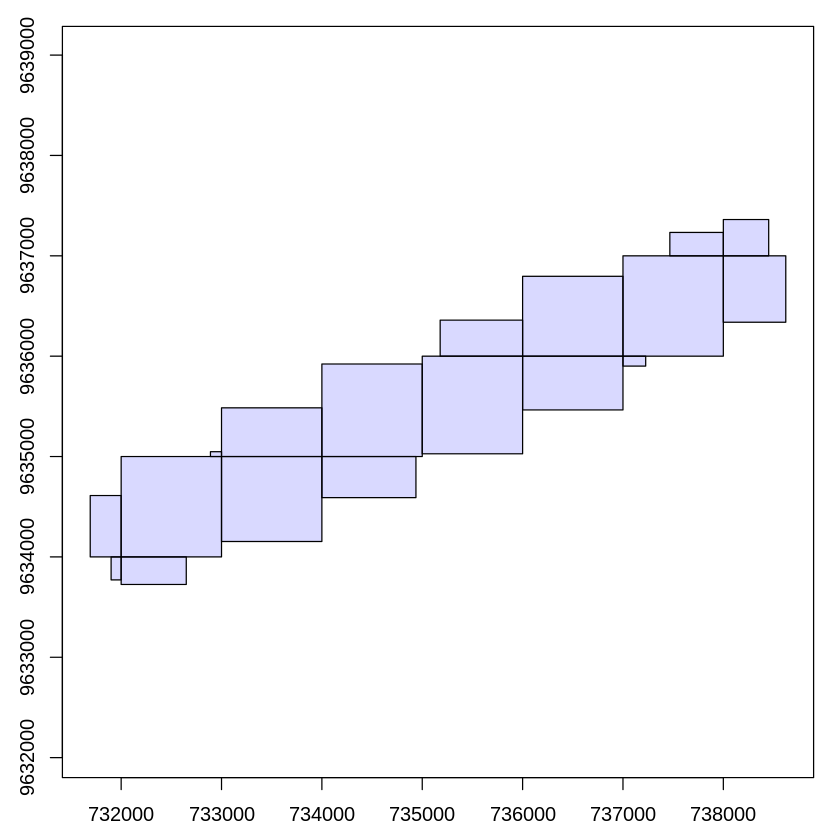

In [14]:
plot(ctg)

Validation

In [12]:
las_check(ctg)


 Checking headers consistency
  - Checking file version consistency... ✓
  - Checking scale consistency... ✓
  - Checking offset consistency... ✓
  - Checking point type consistency... ✓
  - Checking VLR consistency... ✓
  - Checking CRS consistency... ✓
 Checking the headers
  - Checking scale factor validity... ✓
  - Checking Point Data Format ID validity... ✓
 Checking preprocessing already done 
  - Checking negative outliers... ✓
  - Checking normalization... no
 Checking the geometry
  - Checking overlapping tiles... ✓
  - Checking point indexation... no

In [16]:
las_check(ctg, deep=TRUE)



____________________________________
Checking the file: SANL7310C9633.laz
____________________________________

 Checking the data
  - Checking coordinates... ✓
  - Checking coordinates type... ✓
  - Checking coordinates quantization... ✓
  - Checking attributes type... ✓
  - Checking ReturnNumber validity... ✓
  - Checking NumberOfReturns validity... ✓
  - Checking ReturnNumber vs. NumberOfReturns... ✓
  - Checking RGB validity... ✓
  - Checking absence of NAs... ✓
  - Checking duplicated points...
   ⚠ 1016 points are duplicated and share XYZ coordinates with other points
  - Checking degenerated ground points...
   ⚠ There were 25 degenerated ground points. Some X Y Z coordinates were repeated.
  - Checking attribute population...
   ⚠ 'ScanDirectionFlag' attribute is not populated.
   ⚠ 'EdgeOfFlightline' attribute is not populated.
  - Checking gpstime incoherances
    ✗ 14866 pulses (points with the same gpstime) have points with identical ReturnNumber
  - Checking flag attribu

In [8]:
las@proj4string

CRS arguments: NA 

In [12]:
las@bbox

,min,max
x,727450.2,728835
y,9662112.8,9663148


In [14]:
las

class        : LAS (v1.0 format 1)
memory       : 705.7 Mb 
extent       : 727450.2, 728835, 9662113, 9663148 (xmin, xmax, ymin, ymax)
coord. ref.  : NA 
area         : 0.87 kunits²
points       : 9.25 million points
density      : 10.65 points/units²

In [15]:
clip_transect(las, width = 4, xz = TRUE)

ERROR: Error in graphics::locator(2L, type = "o"): plot.new has not been called yet


In [19]:
plot_crossection <- function(las,
                             p1 = c(min(las@data$X), mean(las@data$Y)),
                             p2 = c(max(las@data$X), mean(las@data$Y)),
                             width = 4, 
                             colour_by = NULL)
{
  #colour_by <- enquo(colour_by)
  data_clip <- clip_transect(las, p1, p2, width)
  p <- ggplot(data_clip@data, aes(X,Z)) + geom_point(size = 0.5) + coord_equal() + theme_minimal()

  if (!is.null(colour_by))
    p <- p + aes(color = !!colour_by) + labs(color = "")

  return(p)
}

In [22]:
dtm <- grid_terrain(las, 1, knnidw())
plot(dtm, col = gray.colors(50, 0, 1))

ERROR: Error: No ground points found. Impossible to compute a DTM.


In [27]:
las_check(las)


 Checking the data
  - Checking coordinates... ✓
  - Checking coordinates type... ✓
  - Checking coordinates quantization... ✓
  - Checking attributes type... ✓
  - Checking ReturnNumber validity... ✓
  - Checking NumberOfReturns validity... ✓
  - Checking ReturnNumber vs. NumberOfReturns... ✓
  - Checking RGB validity... ✓
  - Checking absence of NAs... ✓
  - Checking duplicated points...
   ⚠ 18937 points are duplicated and share XYZ coordinates with other points
  - Checking degenerated ground points...
   ⚠ There were 4 degenerated ground points. Some X Y Z coordinates were repeated.
   ⚠ There were 14 degenerated ground points. Some X Y coordinates were repeated but with different Z coordinates.
  - Checking attribute population... ✓
  - Checking gpstime incoherances ✓
  - Checking flag attributes... ✓
  - Checking user data attribute...
   ⚠ 9250115 points have a non 0 UserData attribute. This probably has a meaning.
 Checking the header
  - Checking header completeness... ✓
  -

In [24]:
mycsf <- csf(sloop_smooth = TRUE, class_threshold = 1, cloth_resolution = 1, time_step = 1)
las <- classify_ground(las, mycsf)
nlas <- normalize_height(las, knnidw())

In [26]:
nlas <- normalize_height(las, knnidw())

Warning message:
“There were 4 degenerated ground points. Some X Y Z coordinates were repeated. They were removed.”Warning message:
“There were 14 degenerated ground points. Some X Y coordinates were repeated but with different Z coordinates. min Z were retained.”

ERROR: Error: 9205837 points were not normalizable. Process aborted.


In [20]:
plot_crossection(las)

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.9.1-CAPI-1.14.2
and GEOS at installation 3.9.1dev-CAPI-1.14.1differ”

ERROR: Error in ggplot(data_clip@data, aes(X, Z)): could not find function "ggplot"


In [28]:
nlas

ERROR: Error in eval(expr, envir, enclos): object 'nlas' not found
